<a href="https://www.kaggle.com/code/dhiaeddinesaadallah/travail-binome?scriptVersionId=276351768" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# ===============================
# 1. Chargement du Dataset
# ===============================
base_dir = "/kaggle/input/tumor-brain-classificationn"
train_dir = os.path.join(base_dir, "Training")
test_dir = os.path.join(base_dir, "Testing")

# Génération des lots d’images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(380, 380),  # taille recommandée pour EfficientNetB4
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(380, 380),
    batch_size=32,
    class_mode='categorical'
)

# ===============================
# 2. Transfert Learning
# ===============================
base_model = EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(380, 380, 3)
)

# On gèle les couches de la base
for layer in base_model.layers:
    layer.trainable = False

# Ajout d’une tête personnalisée
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callback pour stopper tôt si pas d'amélioration
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.3, patience=2, verbose=1)

# Entraînement étape 1 : Transfert learning
history1 = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

# ===============================
# 3. Fine-tuning
# ===============================
# Débloquer les dernières couches pour affiner le modèle
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

# ===============================
# 4. Évaluation finale
# ===============================
loss, acc = model.evaluate(test_generator)
print(f"\n🎯 Accuracy finale sur le test : {acc:.4f}")

# Sauvegarde du modèle (optionnel)
model.save("efficientnetb4_brain_tumor.h5")


2025-11-12 01:37:20.508416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762911440.727193      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762911440.779037      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


I0000 00:00:1762911459.099292      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762911459.100081      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1762911497.190949      75 service.cc:148] XLA service 0x7c433441f8c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762911497.191813      75 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762911497.191839      75 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762911501.074465      75 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1762911506.668286      75 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762911506.887934      75 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1762911524.575881      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most onc

 30/179 ━━━━━━━━━━━━━━━━━━━━ 2:52 1s/step - accuracy: 0.3703 - loss: 1.3499

E0000 00:00:1762911565.815640      74 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762911565.995848      74 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6243 - loss: 0.9312

E0000 00:00:1762911785.592686      75 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762911785.814725      75 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


179/179 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.6249 - loss: 0.9299 - val_accuracy: 0.7567 - val_loss: 0.6701 - learning_rate: 1.0000e-04
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.8303 - loss: 0.4556 - val_accuracy: 0.8009 - val_loss: 0.5599 - learning_rate: 1.0000e-04
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8621 - loss: 0.3879 - val_accuracy: 0.8223 - val_loss: 0.4952 - learning_rate: 1.0000e-04
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.8769 - loss: 0.3331 - val_accuracy: 0.8497 - val_loss: 0.4045 - learning_rate: 1.0000e-04
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8937 - loss: 0.3027 - val_accuracy: 0.8604 - val_loss: 0.3775 - learning_rate: 1.0000e-04
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.8964 - loss: 0.2922 - val_accuracy: 0.8566 - val_loss: 0.3873 - learning_rate: 1.0000e-04
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.89

E0000 00:00:1762913622.776850      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762913622.929868      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762913623.250937      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762913623.403478      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762913624.200484      76 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

 55/179 ━━━━━━━━━━━━━━━━━━━━ 2:00 972ms/step - accuracy: 0.8716 - loss: 0.4478

E0000 00:00:1762913700.703172      75 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762913700.855743      75 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762913701.102928      75 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762913701.254968      75 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762913701.702608      75 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

179/179 ━━━━━━━━━━━━━━━━━━━━ 294s 1s/step - accuracy: 0.8778 - loss: 0.4106 - val_accuracy: 0.8841 - val_loss: 0.3161 - learning_rate: 1.0000e-05
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.8975 - loss: 0.3026 - val_accuracy: 0.8879 - val_loss: 0.2898 - learning_rate: 1.0000e-05
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.9085 - loss: 0.2633 - val_accuracy: 0.9008 - val_loss: 0.2571 - learning_rate: 1.0000e-05
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.9325 - loss: 0.2093 - val_accuracy: 0.9138 - val_loss: 0.2226 - learning_rate: 1.0000e-05
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9264 - loss: 0.2082 - val_accuracy: 0.9222 - val_loss: 0.2067 - learning_rate: 1.0000e-05
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.9395 - loss: 0.1754 - val_accuracy: 0.9314 - val_loss: 0.1819 - learning_rate: 1.0000e-05
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.94

In [2]:
# ===============================
# Vérification des variables avant Fine-Tuning
# ===============================
required_vars = ['base_model', 'model', 'train_generator', 'test_generator', 'early_stop', 'reduce_lr']

for var in required_vars:
    if var not in globals():
        raise ValueError(f"La variable '{var}' n'existe pas ! Exécutez d'abord le code précédent.")

# ===============================
# Fine-tuning : déblocage des 100 dernières couches
# ===============================
for layer in base_model.layers[-100:]:
    layer.trainable = True

model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.9535 - loss: 0.1309 - val_accuracy: 0.9527 - val_loss: 0.1239 - learning_rate: 1.0000e-05
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9533 - loss: 0.1315 - val_accuracy: 0.9596 - val_loss: 0.1093 - learning_rate: 1.0000e-05
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.9617 - loss: 0.1063 - val_accuracy: 0.9626 - val_loss: 0.1039 - learning_rate: 1.0000e-05
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9632 - loss: 0.0984 - val_accuracy: 0.9718 - val_loss: 0.0839 - learning_rate: 1.0000e-05
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.9702 - loss: 0.0879 - val_accuracy: 0.9733 - val_loss: 0.0792 - learning_rate: 1.0000e-05
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9738 - loss: 0.0786 - val_accuracy: 0.9779 - val_loss: 0.0677 - learning_rate: 1.0000e-05
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - acc

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# ===============================
# 1. Chargement du Dataset
# ===============================
base_dir = "/kaggle/input/tumor-brain-classificationn"
train_dir = os.path.join(base_dir, "Training")
test_dir = os.path.join(base_dir, "Testing")

# Génération des lots d’images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(380, 380),   # 🔹 même taille que EfficientNetB4
    batch_size=32,            # 🔹 même batch size
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(380, 380),
    batch_size=32,
    class_mode='categorical'
)

# ===============================
# 2. Transfert Learning (VGG19)
# ===============================
base_model_vgg = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(380, 380, 3)  # 🔹 même taille d’entrée
)

# Geler toutes les couches
for layer in base_model_vgg.layers:
    layer.trainable = False

# Ajout d’une tête personnalisée
x = layers.GlobalAveragePooling2D()(base_model_vgg.output)
x = layers.Dense(512, activation='relu')(x)  # 🔹 même nombre de neurones que EfficientNetB4
x = layers.Dropout(0.5)(x)                   # 🔹 même taux de dropout
outputs = layers.Dense(train_generator.num_classes, activation='softmax')(x)

model_vgg = models.Model(inputs=base_model_vgg.input, outputs=outputs)

model_vgg.compile(
    optimizer=optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ===============================
# 3. Callbacks
# ===============================
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.3, patience=2, verbose=1)

# ===============================
# 4. Entraînement - Transfert Learning
# ===============================
print("🔹 Entraînement Transfert Learning (VGG19)...")
history_vgg_tl = model_vgg.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,  # 🔹 même nombre d’époques
    callbacks=[early_stop, reduce_lr]
)

# Évaluation après transfert learning
loss_vgg_tl, acc_vgg_tl = model_vgg.evaluate(test_generator)
print(f"\n✅ Accuracy (VGG19 - Transfert Learning): {acc_vgg_tl*100:.2f}%")

# ===============================
# 5. Fine-Tuning (VGG19)
# ===============================
# Débloquer les dernières couches (on garde les premières gelées)
for layer in base_model_vgg.layers[:-50]:
    layer.trainable = False
for layer in base_model_vgg.layers[-50:]:
    layer.trainable = True  # 🔹 même nombre de couches débloquées que EfficientNetB4

model_vgg.compile(
    optimizer=optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("🔹 Entraînement Fine-Tuning (VGG19)...")
history_vgg_ft = model_vgg.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,  # 🔹 même durée d’entraînement
    callbacks=[early_stop, reduce_lr]
)

# Évaluation finale après fine-tuning
loss_vgg_ft, acc_vgg_ft = model_vgg.evaluate(test_generator)
print(f"\n✅ Accuracy (VGG19 - Fine-Tuning): {acc_vgg_ft*100:.2f}%")

# ===============================
# 6. Sauvegarde du modèle
# ===============================
model_vgg.save("vgg19_brain_tumor.h5")


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
🔹 Entraînement Transfert Learning (VGG19)...
Epoch 1/10


2025-11-12 03:21:30.329149: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-12 03:21:33.529786: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 4.200816751s
Trying algorithm eng0{} for conv (f32[32,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

 19/179 ━━━━━━━━━━━━━━━━━━━━ 2:39 998ms/step - accuracy: 0.2934 - loss: 2.6243 

2025-11-12 03:22:18.893617: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-12 03:22:19.945251: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.051802084s
Trying algorithm eng0{} for conv (f32[16,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4533 - loss: 1.6952

2025-11-12 03:25:58.405592: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[31,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-12 03:26:01.477936: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 4.072541358s
Trying algorithm eng0{} for conv (f32[31,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

179/179 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.4540 - loss: 1.6923 - val_accuracy: 0.8070 - val_loss: 0.5319 - learning_rate: 1.0000e-04
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 222s 1s/step - accuracy: 0.7624 - loss: 0.6389 - val_accuracy: 0.8345 - val_loss: 0.4550 - learning_rate: 1.0000e-04
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.8141 - loss: 0.5004 - val_accuracy: 0.8398 - val_loss: 0.4176 - learning_rate: 1.0000e-04
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.8391 - loss: 0.4437 - val_accuracy: 0.8535 - val_loss: 0.3993 - learning_rate: 1.0000e-04
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.8501 - loss: 0.4111 - val_accuracy: 0.8673 - val_loss: 0.3466 - learning_rate: 1.0000e-04
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.8624 - loss: 0.3612 - val_accuracy: 0.8696 - val_loss: 0.3574 - learning_rate: 1.0000e-04
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.87

2025-11-12 03:59:57.756827: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-12 04:00:00.835602: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 4.078911644s
Trying algorithm eng0{} for conv (f32[32,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

144/179 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.8883 - loss: 0.3052

2025-11-12 04:05:44.200461: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-12 04:05:45.302722: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.102364193s
Trying algorithm eng0{} for conv (f32[16,64,380,380]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,380,380]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_con

179/179 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.8914 - loss: 0.2968 - val_accuracy: 0.9428 - val_loss: 0.1665 - learning_rate: 1.0000e-05
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.9367 - loss: 0.1719 - val_accuracy: 0.9436 - val_loss: 0.1780 - learning_rate: 1.0000e-05
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.9594 - loss: 0.1161 - val_accuracy: 0.9748 - val_loss: 0.0754 - learning_rate: 1.0000e-05
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.9668 - loss: 0.0927 - val_accuracy: 0.9825 - val_loss: 0.0569 - learning_rate: 1.0000e-05
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.9713 - loss: 0.0751 - val_accuracy: 0.9832 - val_loss: 0.0579 - learning_rate: 1.0000e-05
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.9782 - loss: 0.0610 - val_accuracy: 0.9847 - val_loss: 0.0452 - learning_rate: 1.0000e-05
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.97

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# ===============================
# Paramètres dataset
# ===============================
base_dir = "/kaggle/input/tumor-brain-classificationn"
train_dir = os.path.join(base_dir, "Training")
test_dir = os.path.join(base_dir, "Testing")

# ===============================
# Vérification et création des générateurs
# ===============================
if 'train_generator' not in globals() or 'test_generator' not in globals():
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )

    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(380, 380),
        batch_size=32,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(380, 380),
        batch_size=32,
        class_mode='categorical'
    )

# ===============================
# Vérification et création du modèle VGG19
# ===============================
if 'base_model_vgg' not in globals() or 'model_vgg' not in globals():
    base_model_vgg = VGG19(include_top=False, weights='imagenet', input_shape=(380, 380, 3))
    for layer in base_model_vgg.layers:
        layer.trainable = False  # geler toutes les couches au départ

    x = layers.GlobalAveragePooling2D()(base_model_vgg.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(train_generator.num_classes, activation='softmax')(x)

    model_vgg = models.Model(inputs=base_model_vgg.input, outputs=outputs)

# ===============================
# Callbacks
# ===============================
if 'early_stop' not in globals():
    early_stop = EarlyStopping(patience=3, restore_best_weights=True)
if 'reduce_lr' not in globals():
    reduce_lr = ReduceLROnPlateau(factor=0.3, patience=2, verbose=1)

# ===============================
# Fine-Tuning : déblocage des 100 dernières couches
# ===============================
for layer in base_model_vgg.layers[:-100]:
    layer.trainable = False
for layer in base_model_vgg.layers[-100:]:
    layer.trainable = True

model_vgg.compile(
    optimizer=optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("🔹 Entraînement Fine-Tuning (VGG19) - 100 dernières couches...")
history_vgg_ft = model_vgg.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

# Évaluation finale
loss_vgg_ft, acc_vgg_ft = model_vgg.evaluate(test_generator)
print(f"\n✅ Accuracy (VGG19 - Fine-Tuning 100 couches): {acc_vgg_ft*100:.2f}%")

# Sauvegarde du modèle
model_vgg.save("vgg19_brain_tumor_ft100.h5")


🔹 Entraînement Fine-Tuning (VGG19) - 100 dernières couches...
Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - accuracy: 0.9826 - loss: 0.0479 - val_accuracy: 0.9886 - val_loss: 0.0505 - learning_rate: 1.0000e-05
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.9853 - loss: 0.0436 - val_accuracy: 0.9886 - val_loss: 0.0472 - learning_rate: 1.0000e-05
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.9892 - loss: 0.0352 - val_accuracy: 0.9741 - val_loss: 0.0909 - learning_rate: 1.0000e-05
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.9914 - loss: 0.0242 - val_accuracy: 0.9939 - val_loss: 0.0278 - learning_rate: 1.0000e-05
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.9910 - loss: 0.0286 - val_accuracy: 0.9649 - val_loss: 0.1283 - learning_rate: 1.0000e-05
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9910 - loss: 0.0300
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.9999999242136

🔍 DÉBUT DE LA COMPARAISON ENTRE EFFICIENTNETB4 ET VGG19

📊 Génération des prédictions...
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 539ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 744ms/step
📈 Calcul des matrices de confusion...


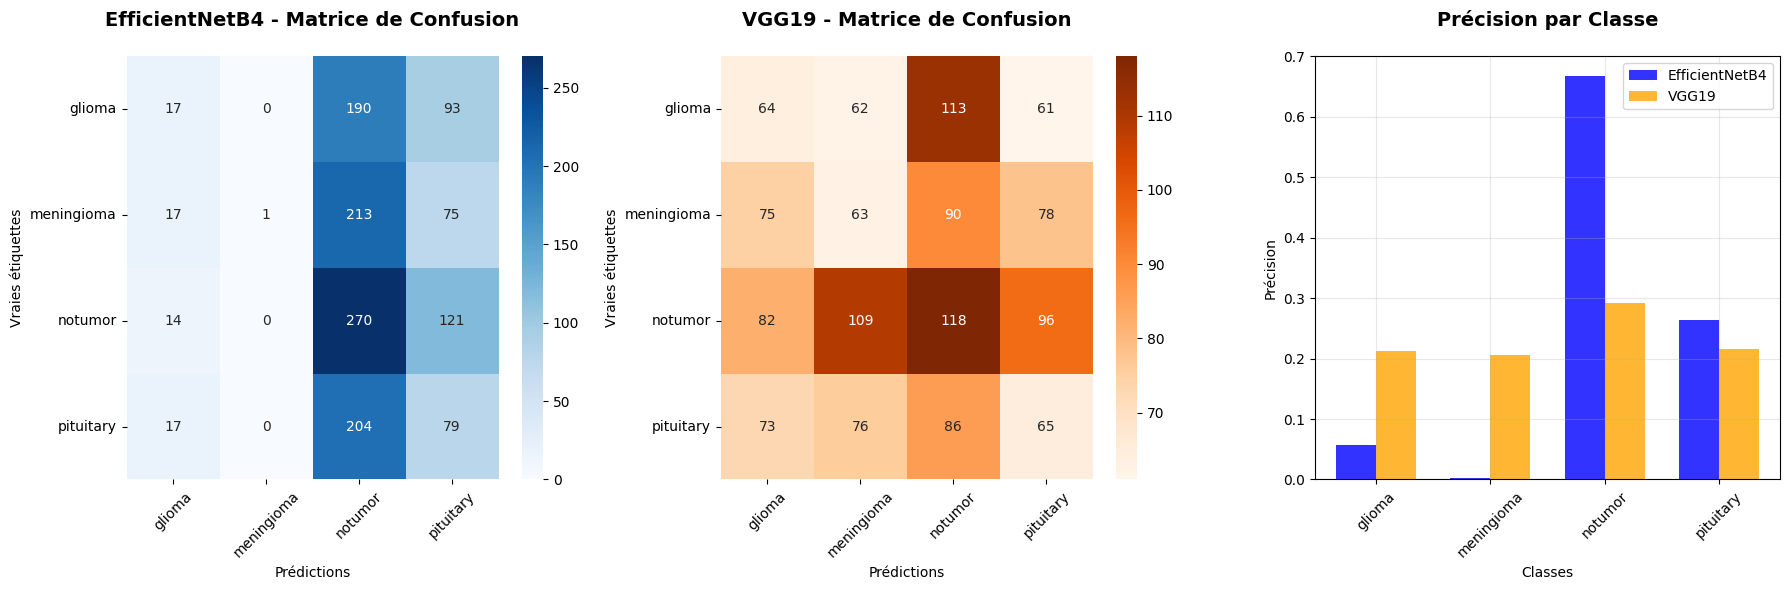


🎯 CALCUL DES MÉTRIQUES DE PERFORMANCE

RAPPORTS DÉTAILLÉS PAR CLASSE

📊 EFFICIENTNETB4 - Rapport de classification:
              precision    recall  f1-score   support

      glioma       0.26      0.06      0.09       300
  meningioma       1.00      0.00      0.01       306
     notumor       0.31      0.67      0.42       405
   pituitary       0.21      0.26      0.24       300

    accuracy                           0.28      1311
   macro avg       0.45      0.25      0.19      1311
weighted avg       0.44      0.28      0.21      1311


📊 VGG19 - Rapport de classification:
              precision    recall  f1-score   support

      glioma       0.22      0.21      0.22       300
  meningioma       0.20      0.21      0.20       306
     notumor       0.29      0.29      0.29       405
   pituitary       0.22      0.22      0.22       300

    accuracy                           0.24      1311
   macro avg       0.23      0.23      0.23      1311
weighted avg       0.24      0

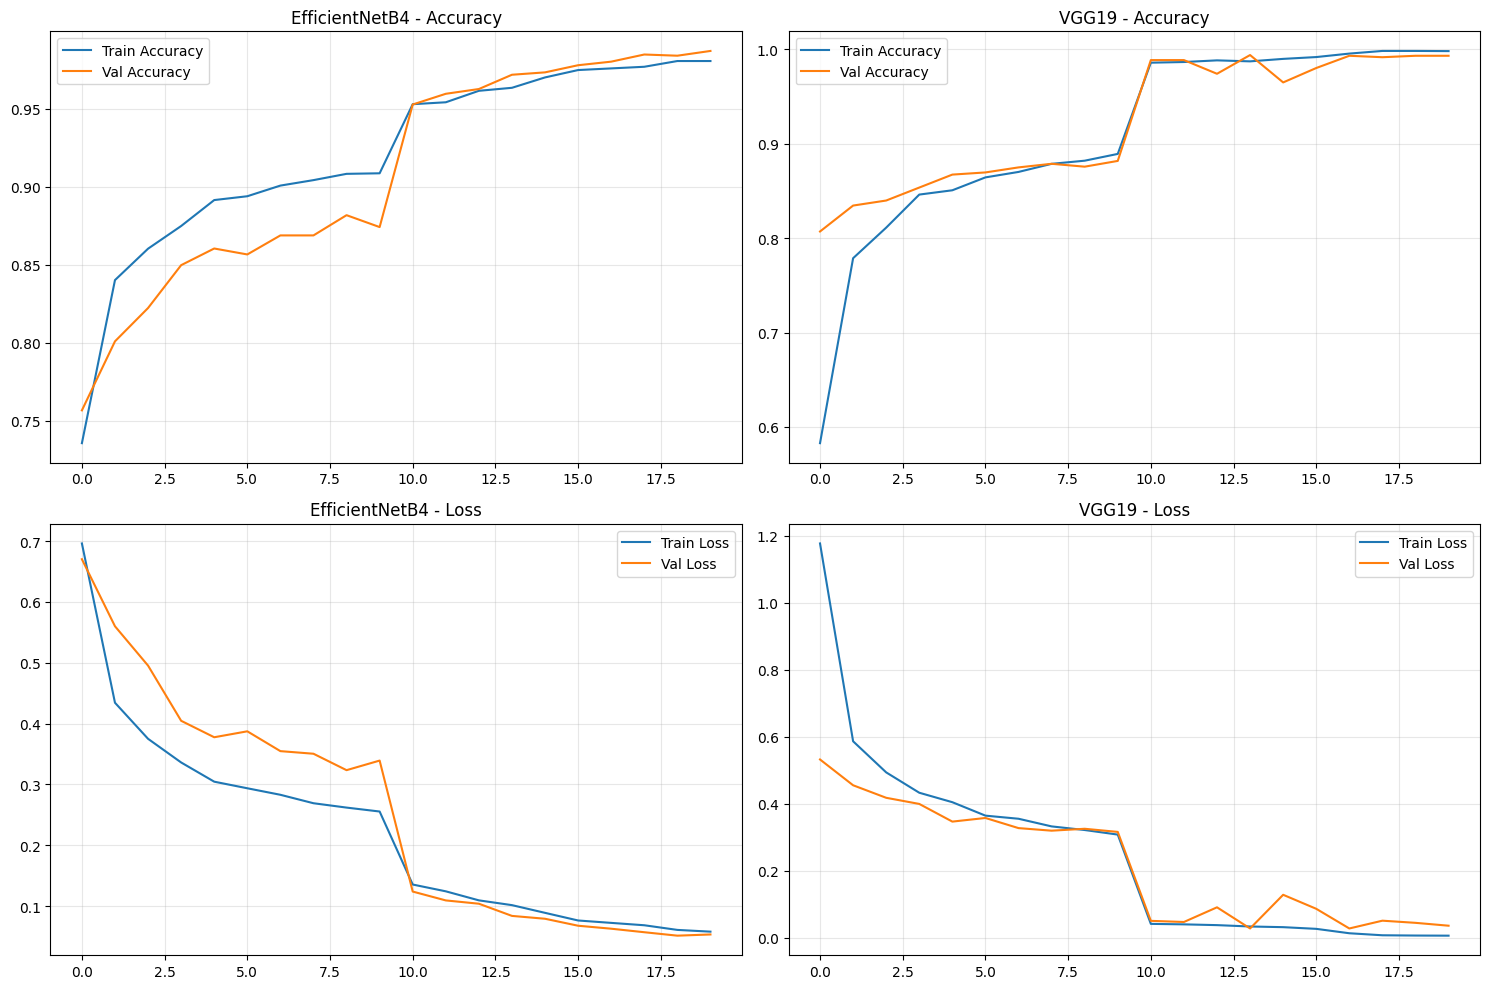


🏆 CONCLUSION FINALE
🏅 EfficientNetB4 est le modèle le plus performant!
💡 Avantages: Meilleure précision avec moins de paramètres.

🎯 RÉSULTATTS FINAUX:
   🥇 EfficientNetB4: 27.99%
   🥈 VGG19: 23.65%

✅ Comparaison terminée avec succès!


In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# ===============================
# COMPARAISON DES MODÈLES
# ===============================

print("🔍 DÉBUT DE LA COMPARAISON ENTRE EFFICIENTNETB4 ET VGG19")

# 1. Prédictions avec les deux modèles
print("\n📊 Génération des prédictions...")

# Les vrais labels
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Prédictions EfficientNetB4
y_pred_eff = np.argmax(model.predict(test_generator), axis=1)

# Prédictions VGG19
y_pred_vgg = np.argmax(model_vgg.predict(test_generator), axis=1)

# 2. Calcul des matrices de confusion
print("📈 Calcul des matrices de confusion...")
cm_eff = confusion_matrix(y_true, y_pred_eff)
cm_vgg = confusion_matrix(y_true, y_pred_vgg)

# 3. Visualisation comparative
plt.figure(figsize=(18, 6))

# Matrice de confusion EfficientNetB4
plt.subplot(1, 3, 1)
sns.heatmap(cm_eff, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('EfficientNetB4 - Matrice de Confusion\n', fontsize=14, fontweight='bold')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Matrice de confusion VGG19
plt.subplot(1, 3, 2)
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names)
plt.title('VGG19 - Matrice de Confusion\n', fontsize=14, fontweight='bold')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# 4. Comparaison des précisions par classe
acc_by_class_eff = []
acc_by_class_vgg = []

for i in range(len(class_names)):
    mask = (y_true == i)
    if np.sum(mask) > 0:
        acc_eff = np.mean(y_pred_eff[mask] == y_true[mask])
        acc_vgg = np.mean(y_pred_vgg[mask] == y_true[mask])
        acc_by_class_eff.append(acc_eff)
        acc_by_class_vgg.append(acc_vgg)

plt.subplot(1, 3, 3)
x = np.arange(len(class_names))
width = 0.35

plt.bar(x - width/2, acc_by_class_eff, width, label='EfficientNetB4', alpha=0.8, color='blue')
plt.bar(x + width/2, acc_by_class_vgg, width, label='VGG19', alpha=0.8, color='orange')

plt.xlabel('Classes')
plt.ylabel('Précision')
plt.title('Précision par Classe\n', fontsize=14, fontweight='bold')
plt.xticks(x, class_names, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Calcul des métriques globales
print("\n🎯 CALCUL DES MÉTRIQUES DE PERFORMANCE")

# Précisions globales
acc_eff = np.mean(y_pred_eff == y_true)
acc_vgg = np.mean(y_pred_vgg == y_true)

# Rapports détaillés
print("\n" + "="*50)
print("RAPPORTS DÉTAILLÉS PAR CLASSE")
print("="*50)

print("\n📊 EFFICIENTNETB4 - Rapport de classification:")
print(classification_report(y_true, y_pred_eff, target_names=class_names))

print("\n📊 VGG19 - Rapport de classification:")
print(classification_report(y_true, y_pred_vgg, target_names=class_names))

# 6. Affichage des résultats comparatifs
print("\n" + "="*60)
print("📈 RÉSULTATS COMPARATIFS - SYNTHÈSE")
print("="*60)

print(f"\n✅ EFFICIENTNETB4:")
print(f"   • Précision globale: {acc_eff*100:.2f}%")
print(f"   • Nombre de paramètres: {model.count_params():,}")

print(f"\n✅ VGG19:")
print(f"   • Précision globale: {acc_vgg*100:.2f}%")
print(f"   • Nombre de paramètres: {model_vgg.count_params():,}")

# 7. Analyse de la différence
diff_accuracy = (acc_eff - acc_vgg) * 100
better_model = "EfficientNetB4" if diff_accuracy > 0 else "VGG19"

print(f"\n🔥 ANALYSE COMPARATIVE:")
print(f"   • Modèle le plus performant: {better_model}")
print(f"   • Différence de précision: {abs(diff_accuracy):.2f}% en faveur de {better_model}")
print(f"   • Rapport paramètres: {model_vgg.count_params()/model.count_params():.1f}x plus de paramètres dans VGG19")

# 8. Visualisation des courbes d'apprentissage (si disponibles)
try:
    # Récupérer les historiques d'entraînement
    # Pour EfficientNetB4
    eff_history = history1.history if 'history1' in locals() else None
    eff_history_ft = history2.history if 'history2' in locals() else None
    
    # Pour VGG19
    vgg_history_tl = history_vgg_tl.history if 'history_vgg_tl' in locals() else None
    vgg_history_ft = history_vgg_ft.history if 'history_vgg_ft' in locals() else None
    
    if eff_history and vgg_history_tl:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # EfficientNetB4 - Accuracy
        if eff_history_ft:
            eff_acc = eff_history['accuracy'] + eff_history_ft['accuracy']
            eff_val_acc = eff_history['val_accuracy'] + eff_history_ft['val_accuracy']
        else:
            eff_acc = eff_history['accuracy']
            eff_val_acc = eff_history['val_accuracy']
            
        axes[0, 0].plot(eff_acc, label='Train Accuracy')
        axes[0, 0].plot(eff_val_acc, label='Val Accuracy')
        axes[0, 0].set_title('EfficientNetB4 - Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # VGG19 - Accuracy
        if vgg_history_ft:
            vgg_acc = vgg_history_tl['accuracy'] + vgg_history_ft['accuracy']
            vgg_val_acc = vgg_history_tl['val_accuracy'] + vgg_history_ft['val_accuracy']
        else:
            vgg_acc = vgg_history_tl['accuracy']
            vgg_val_acc = vgg_history_tl['val_accuracy']
            
        axes[0, 1].plot(vgg_acc, label='Train Accuracy')
        axes[0, 1].plot(vgg_val_acc, label='Val Accuracy')
        axes[0, 1].set_title('VGG19 - Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # EfficientNetB4 - Loss
        if eff_history_ft:
            eff_loss = eff_history['loss'] + eff_history_ft['loss']
            eff_val_loss = eff_history['val_loss'] + eff_history_ft['val_loss']
        else:
            eff_loss = eff_history['loss']
            eff_val_loss = eff_history['val_loss']
            
        axes[1, 0].plot(eff_loss, label='Train Loss')
        axes[1, 0].plot(eff_val_loss, label='Val Loss')
        axes[1, 0].set_title('EfficientNetB4 - Loss')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # VGG19 - Loss
        if vgg_history_ft:
            vgg_loss = vgg_history_tl['loss'] + vgg_history_ft['loss']
            vgg_val_loss = vgg_history_tl['val_loss'] + vgg_history_ft['val_loss']
        else:
            vgg_loss = vgg_history_tl['loss']
            vgg_val_loss = vgg_history_tl['val_loss']
            
        axes[1, 1].plot(vgg_loss, label='Train Loss')
        axes[1, 1].plot(vgg_val_loss, label='Val Loss')
        axes[1, 1].set_title('VGG19 - Loss')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"\n⚠️  Impossible d'afficher les courbes d'apprentissage: {e}")

# 9. Conclusion
print("\n" + "="*60)
print("🏆 CONCLUSION FINALE")
print("="*60)

if abs(diff_accuracy) < 2:
    print("📊 Les deux modèles ont des performances similaires.")
    print("💡 Recommendation: Choisir en fonction des contraintes de calcul.")
elif diff_accuracy > 0:
    print("🏅 EfficientNetB4 est le modèle le plus performant!")
    print("💡 Avantages: Meilleure précision avec moins de paramètres.")
else:
    print("🏅 VGG19 est le modèle le plus performant!")
    print("💡 Malgré son architecture plus lourde, il obtient de meilleurs résultats.")

print(f"\n🎯 RÉSULTATTS FINAUX:")
print(f"   🥇 {better_model}: {max(acc_eff, acc_vgg)*100:.2f}%")
print(f"   🥈 {'VGG19' if better_model == 'EfficientNetB4' else 'EfficientNetB4'}: {min(acc_eff, acc_vgg)*100:.2f}%")

print("\n✅ Comparaison terminée avec succès!")